In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [3]:
exchange_data = pd.read_csv('data//NonLinearRegression//USD-INR small.csv')
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

### Real DataFrame

In [4]:
ind_exchange_data.head()

,Price,Open,High,Low,Change %
Date,,,,,
2017-08-10,64.165,63.898,64.175,63.855,0.48
2017-08-09,63.860,63.780,63.860,63.710,0.26
2017-08-08,63.692,63.750,63.785,63.615,-0.23
2017-08-07,63.840,63.710,63.865,63.648,0.26
2017-08-04,63.675,63.670,63.786,63.572,-0.05


### Reversed and Flipped DataFrame

In [5]:
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Change %,High,Low,Open,Price
Date,,,,,
2017-07-27,-0.36,64.218,64.060,64.18,64.125
2017-07-28,-0.02,64.245,64.105,64.19,64.115
2017-07-31,0.13,64.272,64.045,64.11,64.200
2017-08-01,-0.16,64.145,64.040,64.10,64.095
2017-08-02,-0.72,64.135,63.590,64.12,63.635


In [6]:
df = data_frame[["Price"]]

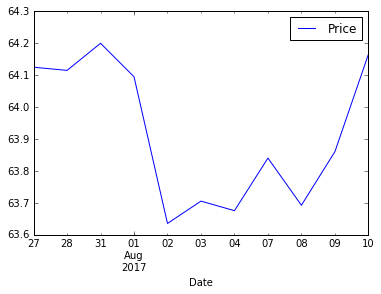

In [7]:
df.plot()

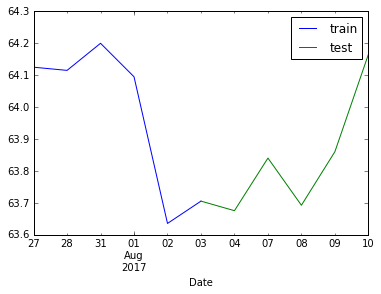

In [12]:
split_date = pd.Timestamp('08-03-2017')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [13]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

# Non-Shifted

## ANN

In [14]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [15]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

Using TensorFlow backend.


In [16]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
#history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

history = model.fit(X_train, y_train, epochs=2, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/2
5/5 [==============================] - 0s 91ms/step - loss: 0.4502
Epoch 2/2
5/5 [==============================] - 0s 2ms/step - loss: 0.4098


In [17]:
y_pred_test_ann = model.predict(X_test)
y_train_pred_ann = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_ann)))
r2_train = r2_score(y_train, y_train_pred_ann)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_ann)))
r2_test = r2_score(y_test, y_pred_test_ann)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

The R2 score on the Train set is:	-1.257
The Adjusted R2 score on the Train set is:	-2.009

The R2 score on the Test set is:	-1.057
The Adjusted R2 score on the Test set is:	-1.743


In [18]:
model.save('ANN_NonShift.h5')

### Process the data for LSTM

In [19]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## LSTM

In [20]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=2, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

Epoch 1/2
5/5 [==============================] - 1s 177ms/step - loss: 1.0730
Epoch 2/2
5/5 [==============================] - 0s 8ms/step - loss: 1.0457
The R2 score on the Train set is:	-5.070
The Adjusted R2 score on the Train set is:	-7.093

The R2 score on the Test set is:	-2.526
The Adjusted R2 score on the Test set is:	-3.702


In [21]:
model_lstm.save('LSTM_NonShift.h5')

## Predictions made by each Model

In [22]:
model_ann = load_model('ANN_NonShift.h5')
model_lstm = load_model('LSTM_NonShift.h5')

In [23]:
score_ann= model_ann.evaluate(X_test, y_test, batch_size=1)
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

5/5 [==============================] - 0s 48ms/step


In [24]:
print('ANN: %f'%score_ann)
print('LSTM: %f'%score_lstm)

ANN: 0.199701
LSTM: 0.342332


In [25]:
y_pred_test_ANN = model_ann.predict(X_test)
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

In [29]:
col1 = pd.DataFrame(y_test, columns=['True'])
col2 = pd.DataFrame(y_pred_test_ANN, columns=['ANN_prediction'])
col3 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])
col4 = pd.DataFrame(history.history['loss'], columns=['Loss_ANN'])
col5 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3, col4, col5], axis=1)
results.to_excel('PredictionResults_ANN-LSTM_NonShift.xlsx')

/opt/ds/lib/python3.4/site-packages/pandas/io/excel.py:687: DeprecationWarning: Call to deprecated function remove_sheet (Use wb.remove(worksheet) or del wb[sheetname]).
  self.book.remove_sheet(self.book.worksheets[0])


### ANN's Prediction Visual

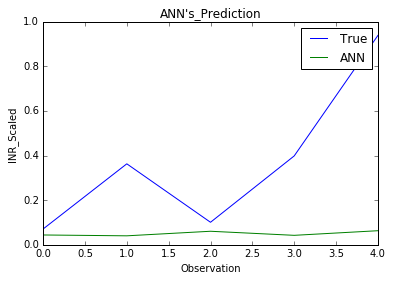

In [30]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_ANN, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

### LSTM's Prediction Visual

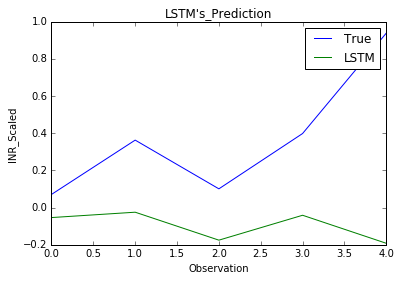

In [31]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()